In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import os

from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau

from IPython.display import display

In [ ]:
METAINFO_COLUMNS_COUNT = 0
INPUT_LAYER_SIZE = 64 * 12
WEIGHT_SCALE = 128.0
PRECISE_WEIGHT_SCALE = 64.0

BATCH_SIZE = 16384

In [ ]:
cuda = torch.device('cuda')

In [ ]:
class NPYDatasetConverter:
    def __init__(self, file_path, chunk_size_mb=10):
        self.file_path = file_path
        self.record_size = 100
        self.chunk_size = chunk_size_mb * 1024 * 1024
        
        self.chunk_size = (self.chunk_size // self.record_size) * self.record_size
        
        file_size = os.path.getsize(file_path)
        self.num_samples = file_size // self.record_size
        
    def convert_to_npy(self, output_prefix):
        all_indices = []
        all_offsets = []
        all_targets = []
        
        current_offset = 0
        
        with open(self.file_path, 'rb') as f:
            while True:
                chunk_bytes = f.read(self.chunk_size)
                if len(chunk_bytes) == 0:
                    break
                    
                indices, offsets, targets = self._process_chunk(chunk_bytes, current_offset)
                
                if len(targets) > 0:
                    all_indices.append(indices)
                    all_offsets.append(offsets)
                    all_targets.append(targets)
                    
                    current_offset += len(indices)
        
        if all_indices:
            all_indices = np.concatenate(all_indices)
            all_offsets = np.concatenate(all_offsets)
            all_targets = np.concatenate(all_targets)
            
            np.save(f"{output_prefix}_indices.npy", all_indices)
            np.save(f"{output_prefix}_offsets.npy", all_offsets)
            np.save(f"{output_prefix}_targets.npy", all_targets)
            
            print(f"Conversion complete. Samples: {len(all_targets)}")
        else:
            print("No data found in file")
        
    def _process_chunk(self, chunk_bytes, global_offset):
        chunk_size = len(chunk_bytes)
        full_records_size = (chunk_size // self.record_size) * self.record_size
        
        if full_records_size == 0:
            return np.array([], dtype=np.int64), np.array([], dtype=np.int64), np.array([], dtype=np.float32)
        
        chunk_bytes = chunk_bytes[:full_records_size]
        num_records = full_records_size // self.record_size
        
        chunk_array = np.frombuffer(chunk_bytes, dtype=np.uint8)
        batch_bytes = chunk_array.reshape(num_records, self.record_size)
        
        targets = np.frombuffer(batch_bytes[:, 96:].tobytes(), dtype='<f4').copy()
        
        features_packed = batch_bytes[:, :96]
        features = np.unpackbits(features_packed, axis=1)
        nonzero_mask = features == 1
        
        _, feature_indices = np.where(nonzero_mask)
        indices = feature_indices.astype(np.int64)
        
        counts = np.sum(nonzero_mask, axis=1)
        offsets_array = np.concatenate([[0], np.cumsum(counts)[:-1]]).copy()
        offsets = offsets_array.astype(np.int64) + global_offset
        
        return indices, offsets, targets

In [ ]:
class NPYDataset(Dataset):
    def __init__(self, prefix):
        indices = np.load(f"{prefix}_indices.npy")
        offsets = np.load(f"{prefix}_offsets.npy")
        targets = np.load(f"{prefix}_targets.npy")

        self.indices = torch.from_numpy(indices).long()
        self.targets = torch.from_numpy(targets).float()

        offsets = torch.from_numpy(offsets).long()
        total_indices = torch.tensor([self.indices.shape[0]], dtype=torch.long, device=self.indices.device)
        self.offsets = torch.cat((offsets, total_indices))
        self.sample_offsets = self.offsets[:-1]
        self.lengths = self.offsets[1:] - self.sample_offsets

    def __len__(self):
        return self.targets.shape[0]

    def __getitem__(self, idx):
        return int(idx)

    def collate_fn(self, batch_indices):
        batch_indices = torch.as_tensor(batch_indices, dtype=torch.long, device=self.indices.device)

        lengths = self.lengths.index_select(0, batch_indices)
        sample_starts = self.sample_offsets.index_select(0, batch_indices)
        prefix = torch.cumsum(lengths, dim=0) - lengths
        total_elems = int(lengths.sum().item())

        base = sample_starts - prefix
        expanded_base = base.repeat_interleave(lengths)
        positions = torch.arange(total_elems, device=self.indices.device, dtype=torch.long)
        positions = positions + expanded_base
        indices = self.indices.index_select(0, positions)

        offsets = prefix
        targets = self.targets.index_select(0, batch_indices)

        return (indices, offsets), targets

In [ ]:
class CompressedDataset(Dataset):
    def __init__(self, file_path):
        with open(file_path, 'rb') as f:
            self.compressed_data = f.read()
        self.record_size = 100
        self.num_samples = len(self.compressed_data) // self.record_size
        
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        start = idx * self.record_size
        end = start + self.record_size
        record_bytes = self.compressed_data[start:end]
        return record_bytes

    def collate_fn(self, batch):
        batch_bytes = np.frombuffer(b''.join(batch), dtype=np.uint8)
        batch_size = len(batch)
        batch_bytes = batch_bytes.reshape(batch_size, -1)
        
        targets = np.frombuffer(batch_bytes[:, 96:].tobytes(), dtype='<f4').copy()
        
        features_packed = batch_bytes[:, :96]
        
        features = np.unpackbits(features_packed, axis=1)
        
        nonzero_mask = features == 1
        _, feature_indices = np.where(nonzero_mask)
        
        indices = torch.from_numpy(feature_indices.copy()).long()
        
        counts = np.sum(nonzero_mask, axis=1)
        
        offsets_array = np.concatenate([[0], np.cumsum(counts)[:-1]]).copy()
        offsets = torch.from_numpy(offsets_array).long()
        
        targets_tensor = torch.from_numpy(targets).float()
        return (indices, offsets), targets_tensor

In [ ]:
# Use this when RAM is more important than CPU

dataset = CompressedDataset('/home/wind-eagle/Chess/dataset/2_0/train.qds')
testset = CompressedDataset('/home/wind-eagle/Chess/dataset/2_0/test.qds')

In [ ]:
# Use this when CPU is more important than RAM

# converter = NPYDatasetConverter("/home/wind-eagle/Chess/dataset/train.qds")
# converter.convert_to_npy("train")
# converter = NPYDatasetConverter("/home/wind-eagle/Chess/dataset/test.qds")
# converter.convert_to_npy("test")

In [ ]:
# dataset = NPYDataset("train")
# testset = NPYDataset("test")

In [ ]:
loader = DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=6,
        prefetch_factor=4,
        pin_memory=True,
        persistent_workers=True,
        collate_fn=dataset.collate_fn
    )

test_loader = DataLoader(
        testset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=6,
        prefetch_factor=4,
        pin_memory=True,
        persistent_workers=True,
        collate_fn=testset.collate_fn
    )

In [ ]:
class ClippedReLU(nn.Module):
    def __init__(self, clip_value: float):
        super(ClippedReLU, self).__init__()
        self.clip_value = clip_value

    def forward(self, x):
        return torch.clamp(x.relu(), max=self.clip_value)

In [ ]:
class QNNE(nn.Module):
    def __init__(self):
        super(QNNE, self).__init__()

        self.embedding_bag = nn.EmbeddingBag(
            num_embeddings=768,
            embedding_dim=256,
            mode='sum',
            sparse=False,
            device=cuda
        )
        
        self.embedding_bias = nn.Parameter(torch.zeros(256))
        
        self.feature = nn.Sequential()
        self.main = nn.Sequential()

        self.feature.add_module('clipped_relu1', ClippedReLU(1.0))

        self.main.add_module('first', nn.Linear(512, 16))
        self.main.add_module('clipped_relu2', ClippedReLU(1.0))

        self.main.add_module('second', nn.Linear(16, 32))
        self.main.add_module('clipped_relu3', ClippedReLU(1.0))

        self.main.add_module('third', nn.Linear(32, 1))
        self.main.add_module('sigmoid', nn.Sigmoid())

        self.register_buffer('xor_indices', self._create_xor_indices())
        self.register_buffer('branch2_mapping', self._create_branch2_mapping())

    def _create_xor_indices(self):
        xor_indices = torch.zeros(768, dtype=torch.long)
        for i in range(768):
            xor_indices[i] = (i % 64) ^ 56 + (i // 64) * 64
        return xor_indices

    def _create_branch2_mapping(self):
        mapping = torch.zeros(768, dtype=torch.long)
        rearranged = torch.cat([torch.arange(384, 768), torch.arange(0, 384)])
        for i in range(768):
            mapping[i] = rearranged[self.xor_indices[i]]
        return mapping

    def forward(self, x):
        indices, offsets = x

        embedded1 = self.embedding_bag(indices, offsets) + self.embedding_bias.to(device=cuda)
        branch1 = self.feature(embedded1)
        
        branch2_indices = self.branch2_mapping.to(device=cuda)[indices]
        embedded2 = self.embedding_bag(branch2_indices, offsets) + self.embedding_bias.to(device=cuda)
        branch2 = self.feature(embedded2)
        
        combined = torch.cat((branch1, branch2), dim=1)
        return self.main(combined)[:, 0]

In [ ]:
def get_loss(model, X, y):
    y = (y + 1.0) / 2
    y_pred = model(X)
    assert y_pred.dim() == 1
    loss = torch.sum((y - y_pred) ** 2) / y_pred.shape[0]
    return loss

In [ ]:
plt.rcParams.update({ 'figure.facecolor': 'black', 'axes.facecolor': 'black', 'text.color': 'white', 'axes.labelcolor': 'white', 'xtick.color': 'white', 'ytick.color': 'white' })

In [ ]:
def train_model(model, opt, scheduler, lr_limit):    
    fig = plt.figure()
    axes = fig.add_subplot()
    hfig = display(fig, display_id=True)
    train_plot_data_x, train_plot_data_y, test_plot_data_y = [], [], []
    axes.plot(train_plot_data_x, train_plot_data_y)
    fig.canvas.draw()
    hfig.update(fig)

    epoch_num = 0
    with tqdm() as progress:
        while True:
            if opt.param_groups[0]["lr"] + 1e-9 < lr_limit:
                break
            history = []
            test_history = []
            for features, targets in loader:
                indices, offsets = features
                indices = indices.to(cuda, non_blocking=True)
                offsets = offsets.to(cuda, non_blocking=True)
                targets = targets.to(cuda, non_blocking=True)
                
                loss = get_loss(model, (indices, offsets), targets)

                loss.backward()
                
                opt.step()
                opt.zero_grad()

                with torch.no_grad():
                    model.main.first.weight.data = torch.clamp(model.main.first.weight.data, min=-128.0 / WEIGHT_SCALE, max=127.0 / WEIGHT_SCALE)
                    model.main.second.weight.data = torch.clamp(model.main.second.weight.data, min=-32768.0 / WEIGHT_SCALE / PRECISE_WEIGHT_SCALE, max=32767.0 / WEIGHT_SCALE / PRECISE_WEIGHT_SCALE)

                history.append(loss.data.cpu().numpy())

            for features, targets in test_loader:
                indices, offsets = features
                indices = indices.to(cuda, non_blocking=True)
                offsets = offsets.to(cuda, non_blocking=True)
                targets = targets.to(cuda, non_blocking=True)
                
                loss = get_loss(model, (indices, offsets), targets)
                test_history.append(loss.data.cpu().numpy())
            
            train_loss = sum(history) / len(history)
            test_loss = sum(test_history) / len(test_history)

            scheduler.step(test_loss)

            train_plot_data_x.append(epoch_num)
            train_plot_data_y.append(train_loss)
            test_plot_data_y.append(test_loss)

            axes.cla()
            axes.plot(train_plot_data_x[-50:], train_plot_data_y[-50:])
            axes.plot(train_plot_data_x[-50:], test_plot_data_y[-50:])
            fig.canvas.draw()
            hfig.update(fig)

            epoch_num += 1
            progress.update(1)
            progress.set_description(f'Average batch loss = {train_loss:.6f}, average test loss = {test_loss:.6f}, lr = {opt.param_groups[0]["lr"]:.6f}')


In [ ]:
def print_weights(f, arr):
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            print("{0:0.5f}".format(arr[i][j]), ' ', file=f, sep="", end="")

def print_biases(f, arr):
    for i in range(arr.shape[0]):
            print("{0:0.5f}".format(arr[i]), ' ', file=f, sep="", end="")

def print_model(model, name):
    with open(name, 'w') as f:
        feature_transformer_weights = model.embedding_bag.weight.detach().cpu().numpy()
        feature_transformer_biases = model.embedding_bias.detach().cpu().numpy()
        
        print_weights(f, feature_transformer_weights)
        print_biases(f, feature_transformer_biases)
        
        print_weights(f, model.main.first.weight.T.detach().cpu().numpy())
        print_biases(f, model.main.first.bias.detach().cpu().numpy())
        print_weights(f, model.main.second.weight.T.detach().cpu().numpy())
        print_biases(f, model.main.second.bias.detach().cpu().numpy())
        print_weights(f, model.main.third.weight.T.detach().cpu().numpy())
        print_biases(f, model.main.third.bias.detach().cpu().numpy())

In [ ]:
import gc
gc.collect()
model = QNNE().to(cuda)

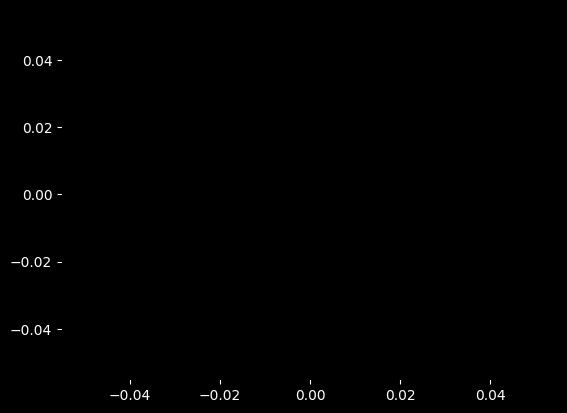

0it [00:00, ?it/s]


TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/wind-eagle/.venv/lib/python3.12/site-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/wind-eagle/.venv/lib/python3.12/site-packages/torch/utils/data/_utils/fetch.py", line 55, in fetch
    return self.collate_fn(data)
           ^^^^^^^^^^^^^^^^^^^^^
TypeError: CompressedDataset.collate_fn() takes 1 positional argument but 2 were given


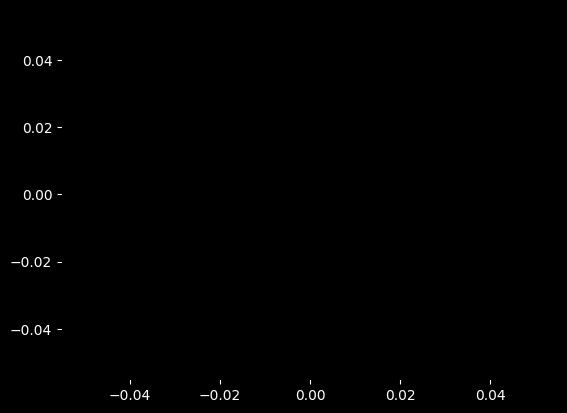

In [ ]:
opt = torch.optim.Adam(model.parameters(), lr=0.01 * np.cbrt(0.1), weight_decay=7e-6)
scheduler = ReduceLROnPlateau(opt, patience=16, factor=np.cbrt(0.1))
train_model(model, opt, scheduler, 0.001 * np.cbrt(0.1) * np.cbrt(0.1))
scheduler = ReduceLROnPlateau(opt, patience=4, factor=np.cbrt(0.1))
train_model(model, opt, scheduler, 0.0001)
scheduler = ReduceLROnPlateau(opt, patience=2, factor=np.cbrt(0.1))
train_model(model, opt, scheduler, 0.00001)
scheduler = ReduceLROnPlateau(opt, patience=1, factor=np.cbrt(0.1))
train_model(model, opt, scheduler, 0.000001)

In [ ]:
print_model(model, 'model.qnne')